In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Wed Sep 24 10:32:54 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = ['united_states_of_america',
#              'china',
#              'brazil',
#              'japan',
#              'sweden',
#              'united_kingdom',
            ]



results_dirs = [
    'results/model5.0/united_states_of_america/2025_09_24_09_05_46/results/',
]

artifact_dirs = ['artifacts/model5.0/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model5.0/united_states_of_america.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [5]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [6]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        
        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [7]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [8]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [9]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        1.368546e+08
alzheimers_disease_state                      1.524054e+08
alzheimers_mild_cognitive_impairment_state    7.242251e+07
Name: value, dtype: float64

In [10]:
person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                       alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
United_States_Of_America 2025         25_to_29                                 3.507187   
                                      30_to_34                              1738.061602   
                                      35_to_39                              1923.942505   
                                      40_to_44                              1836.763860   
                                      45_to_49                              5557.388090   
...                                                                                 ...   
                         2100         75_to_79                            348738.628337   
                                      80_to_84                            412105.478439   
                                      85_to_89                            372248.804928   
                                      90_to_94                            186205.568789   
                                      95_plus                              50102.168378   

sub_entity                                       alzheimers_disease_state  \
location                 current_year age_group                             
United_States_Of_America 2025         25_to_29                   0.000000   
                                      30_to_34                  72.648871   
                                      35_to_39                  85.675565   
                                      40_to_44                  63.129363   
                                      45_to_49                 202.414784   
...                                                                   ...   
                         2100         75_to_79              352624.090349   
                                      80_to_84              499480.525667   
                                      85_to_89              524914.143737   
                                      90_to_94              338554.258727   
                                      95_plus               125784.755647   

sub_entity                                       alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
United_States_Of_America 2025         25_to_29                                     1.503080  
                                      30_to_34                                   986.521561  
                                      35_to_39                                  1127.310062  
                                      40_to_44                                  1148.353183  
                                      45_to_49                                  3277.215606  
...                                                                                     ...  
                         2100         75_to_79                                182783.556468  
                                      80_to_84                                217053.782341  
                                      85_to_89                                198014.767967  
                                      90_to_94                                 99273.930185  
                                      95_plus                                  29774.012320  

[1140 rows x 3 columns]

In [11]:
assert np.all(person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

AssertionError: 

## Verify that there are no transitions out of susceptible state during the simulation 

In [12]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [13]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [14]:
assert np.all(trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

AssertionError: 

## Next look at the transition rates and approximate durations for BBBM and MCI

In [15]:
out_counts = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
out_counts

alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
United_States_Of_America 2025         25_to_29                                      0.0   
                                      30_to_34                                    122.0   
                                      35_to_39                                    145.0   
                                      40_to_44                                    134.0   
                                      45_to_49                                    355.0   
...                                                                                 ...   
                         2100         75_to_79                                  26508.0   
                                      80_to_84                                  32961.0   
                                      85_to_89                                  30762.0   
                                      90_to_94                                  17686.0   
                                      95_plus                                    5498.0   

                                                 alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
United_States_Of_America 2025         25_to_29                                          1.0  
                                      30_to_34                                        249.0  
                                      35_to_39                                        310.0  
                                      40_to_44                                        268.0  
                                      45_to_49                                        776.0  
...                                                                                     ...  
                         2100         75_to_79                                      45093.0  
                                      80_to_84                                      54700.0  
                                      85_to_89                                      50332.0  
                                      90_to_94                                      27139.0  
                                      95_plus                                        7869.0  

[1140 rows x 2 columns]

In [16]:
out_rates = out_counts / person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_rates['alzheimers_blood_based_biomarker_state'].unstack()

age_group                              25_to_29  30_to_34  35_to_39  40_to_44  \
location                 current_year                                           
United_States_Of_America 2025          0.000000  0.070193  0.075366  0.072954   
                         2026          0.190086  0.065621  0.064270  0.064082   
                         2027          0.000000  0.071106  0.071367  0.073264   
                         2028          0.064384  0.061099  0.077589  0.067759   
                         2029          0.137648  0.059358  0.071338  0.074826   
...                                         ...       ...       ...       ...   
                         2096          0.071282  0.057953  0.071016  0.071329   
                         2097          0.133060  0.058847  0.068094  0.071122   
                         2098          0.079836  0.068417  0.064346  0.064654   
                         2099          0.000000  0.061412  0.062972  0.069850   
                         2100          0.073922  0.045911  0.063304  0.073327   

age_group                              45_to_49  50_to_54  55_to_59  60_to_64  \
location                 current_year                                           
United_States_Of_America 2025          0.063879  0.071455  0.067187  0.066291   
                         2026          0.073804  0.072975  0.068326  0.067050   
                         2027          0.069520  0.072963  0.068570  0.068222   
                         2028          0.063947  0.070157  0.069502  0.069764   
                         2029          0.063005  0.076252  0.069803  0.067680   
...                                         ...       ...       ...       ...   
                         2096          0.071989  0.073207  0.069418  0.069508   
                         2097          0.072265  0.072999  0.071893  0.072102   
                         2098          0.071329  0.071662  0.071819  0.071098   
                         2099          0.076014  0.077213  0.067360  0.069844   
                         2100          0.076233  0.072569  0.069693  0.071402   

age_group                              65_to_69  70_to_74  75_to_79  80_to_84  \
location                 current_year                                           
United_States_Of_America 2025          0.067082  0.068737  0.071255  0.072600   
                         2026          0.067886  0.070105  0.072218  0.076283   
                         2027          0.067879  0.070238  0.074125  0.077984   
                         2028          0.068140  0.070653  0.074862  0.078865   
                         2029          0.067973  0.070757  0.074401  0.079421   
...                                         ...       ...       ...       ...   
                         2096          0.071779  0.071976  0.075743  0.080077   
                         2097          0.071622  0.073821  0.076208  0.079530   
                         2098          0.072423  0.073140  0.075354  0.079728   
                         2099          0.071532  0.072718  0.076284  0.079836   
                         2100          0.071805  0.073175  0.076011  0.079982   

age_group                              85_to_89  90_to_94   95_plus  
location                 current_year                                
United_States_Of_America 2025          0.073207  0.073413  0.122062  
                         2026          0.077882  0.081061  0.094997  
                         2027          0.080449  0.086943  0.094410  
                         2028          0.080207  0.090424  0.094128  
                         2029          0.081029  0.090395  0.092272  
...                                         ...       ...       ...  
                         2096          0.082209  0.094382  0.109773  
                         2097          0.082297  0.094330  0.110522  
                         2098          0.082915  0.095108  0.110958  
                         2099          0.082253  0.095985  0.109200 

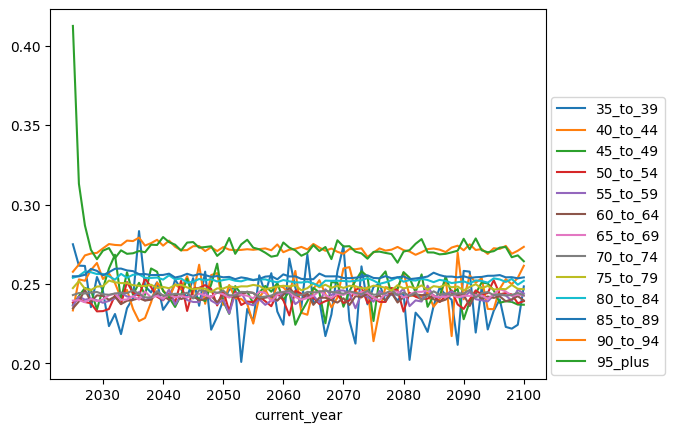

In [18]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,2:].plot()
plt.legend(loc=(1.01, .01));

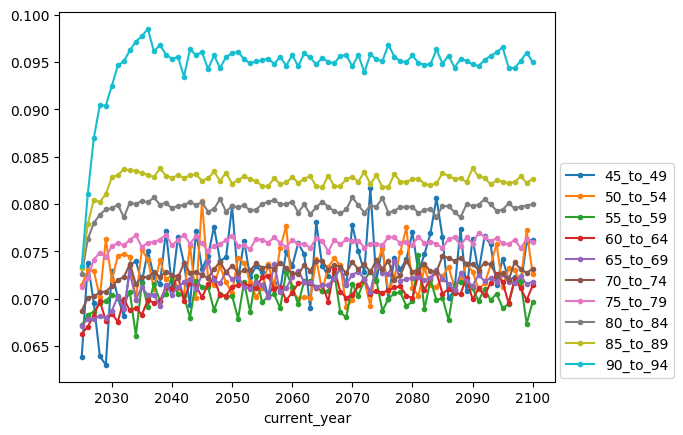

In [19]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,4:14].plot(marker='.')
plt.legend(loc=(1.01, .01));

In [20]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
mci_duration_est

location                  current_year  age_group
United_States_Of_America  2025          25_to_29          inf
                                        30_to_34     8.086242
                                        35_to_39     7.774552
                                        40_to_44     8.569800
                                        45_to_49     9.231593
                                                       ...   
                          2100          75_to_79     6.895411
                                        80_to_84     6.585170
                                        85_to_89     6.436993
                                        90_to_94     5.613136
                                        95_plus      5.415426
Length: 1140, dtype: float64

In [21]:
new_sims = load_df('new_simulants').groupby(['location', 'current_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
bbbm_duration_est

location                  current_year  age_group
United_States_Of_America  2025          25_to_29     0.250513
                                        30_to_34     7.333593
                                        35_to_39     2.800499
                                        40_to_44     1.631229
                                        45_to_49     3.159402
                                                       ...   
                          2100          75_to_79     3.537764
                                        80_to_84     4.114020
                                        85_to_89     4.375640
                                        90_to_94          inf
                                        95_plus           inf
Length: 1140, dtype: float64

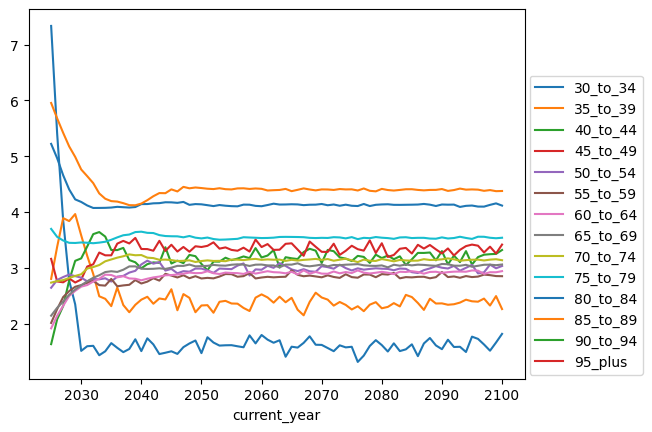

In [22]:
t = bbbm_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

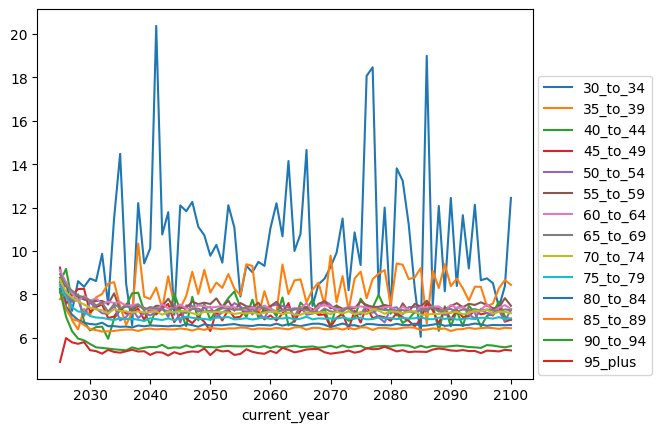

In [23]:
t = mci_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [24]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 21.1 s, sys: 177 ms, total: 21.2 s
Wall time: 20.8 s


In [25]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,30 to 34,30_to_34,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,Male,95.0,125.0,2046,2047,0.255483,0.183408,0.309304,33,95 to 99,95_plus,acmr,United_States_Of_America
808,Male,95.0,125.0,2047,2048,0.255328,0.183463,0.309327,33,95 to 99,95_plus,acmr,United_States_Of_America
809,Male,95.0,125.0,2048,2049,0.255440,0.183938,0.309749,33,95 to 99,95_plus,acmr,United_States_Of_America
810,Male,95.0,125.0,2049,2050,0.255137,0.183684,0.310288,33,95 to 99,95_plus,acmr,United_States_Of_America


In [26]:
art_data = art_ocmr
location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [27]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


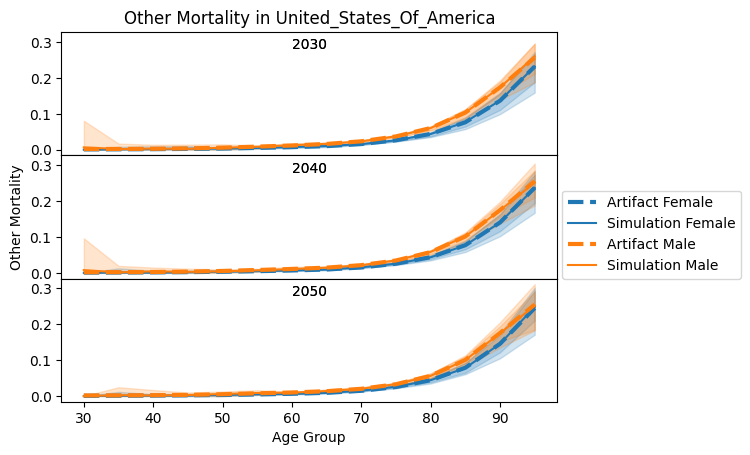

In [28]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [29]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

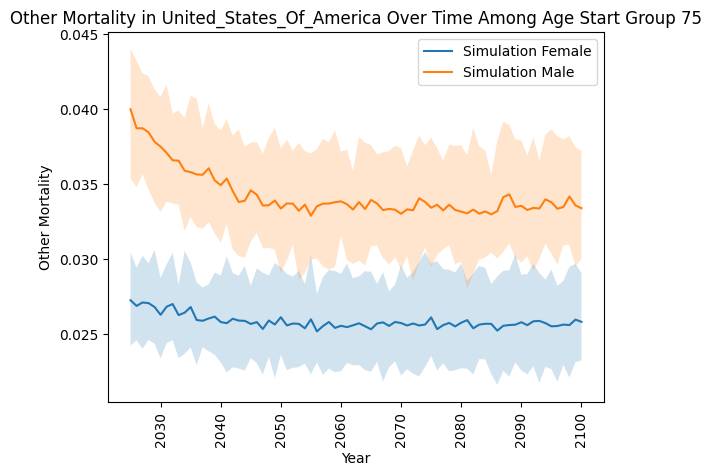

<Figure size 640x480 with 0 Axes>

In [30]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [31]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [32]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [33]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

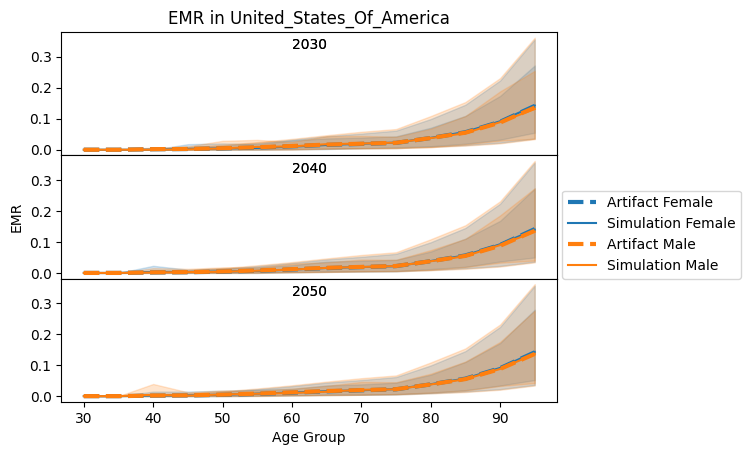

In [34]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

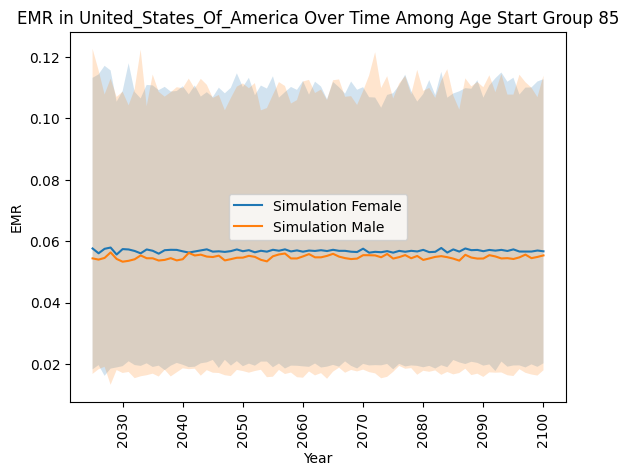

<Figure size 640x480 with 0 Axes>

In [35]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [37]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [47]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [38]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
United_States_Of_America,168.0,0.001344,0.0,0.001344,0.001344,0.001344,0.001344,0.001344


In [48]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
# new_sims

In [49]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [50]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [52]:
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,value,location,ratio
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,baseline,2,6.0,United_States_Of_America,0.018284
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,baseline,13,7.0,United_States_Of_America,0.018284
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,baseline,24,11.0,United_States_Of_America,0.018284
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,baseline,41,7.0,United_States_Of_America,0.018284
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,baseline,46,3.0,United_States_Of_America,0.018284
...,...,...,...,...,...,...,...,...,...,...,...,...
18195,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,baseline,446,70.0,United_States_Of_America,0.018284
18196,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,baseline,457,81.0,United_States_Of_America,0.018284
18197,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,baseline,460,85.0,United_States_Of_America,0.018284
18198,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,baseline,480,98.0,United_States_Of_America,0.018284


In [53]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [54]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,25.0,389.418197,131.454332,164.080701,164.080701,382.854969,656.322803,656.322803,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,25.0,155.329730,110.159235,0.000000,32.816140,164.080701,360.977542,492.242102,11,30 to 34,30.0,35.0
2,2026,United_States_Of_America,30_to_34,Female,25.0,255.965893,127.995412,54.693567,54.693567,218.774268,492.242102,492.242102,11,30 to 34,30.0,35.0
3,2026,United_States_Of_America,30_to_34,Male,25.0,126.889075,109.067621,0.000000,0.000000,109.387134,350.038828,382.854969,11,30 to 34,30.0,35.0
4,2027,United_States_Of_America,30_to_34,Female,25.0,113.762619,106.990832,0.000000,0.000000,109.387134,339.100115,437.548536,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2048,United_States_Of_America,95_plus,Male,25.0,4806.470663,717.528738,3664.468985,3730.101265,4758.340324,6224.127918,6453.840899,33,95 to 99,95.0,125.0
724,2049,United_States_Of_America,95_plus,Female,25.0,11356.572240,1676.194987,8532.196443,8860.357845,11102.794089,15040.730909,15204.811610,33,95 to 99,95.0,125.0
725,2049,United_States_Of_America,95_plus,Male,25.0,4841.474546,685.330254,3773.856119,3773.856119,4703.646757,6158.495638,6617.921600,33,95 to 99,95.0,125.0
726,2050,United_States_Of_America,95_plus,Female,25.0,11737.239466,1717.122514,8313.422175,8740.031997,11813.810459,14712.569507,15532.973011,33,95 to 99,95.0,125.0


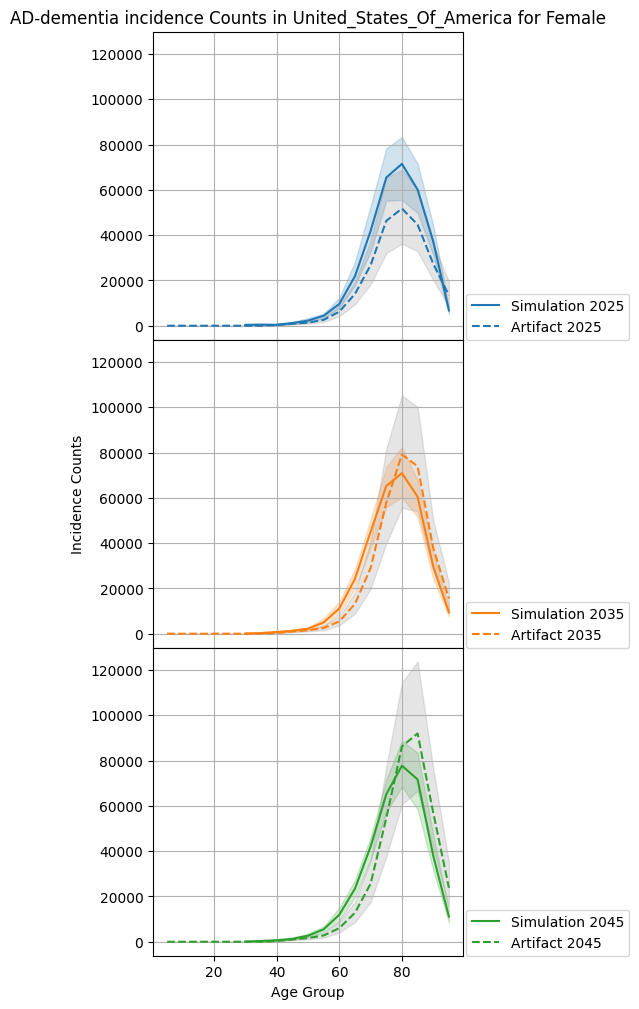

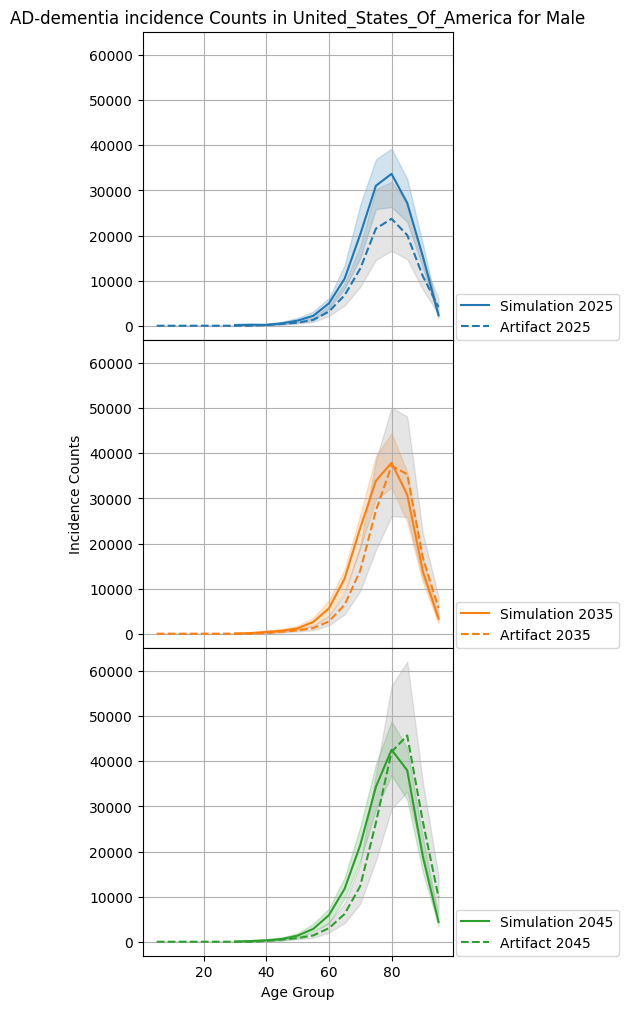

In [55]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


## Verifying Prevalence

In [56]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      162563.021390   
                                                  2047       2048      166675.916483   
                                                  2048       2049      170942.640904   
                                                  2049       2050      175181.374984   
                                                  2050       2051      179116.633125   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      166993.935612   
                                                  2047       2048      171817.333284   
                                                  2048       2049      176968.591455   
                                                  2049       2050      182051.190909   
                                                  2050       2051      186616.966475   

                                                                              draw_2  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      133964.368713   
                                                  2047       2048      137691.568246   
                                                  2048       2049      141556.847175   
                                                  2049       2050      145356.075146   
                                                  2050       2051      148913.015990   

                                                                              draw_3  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                        

In [57]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,United_States_Of_America,95_plus,Male,25.0,113448.159305,24302.169731,83907.793187,85354.668262,108570.436514,159802.967586,168993.912666,33,95 to 99,95.0,125.0
724,2049,United_States_Of_America,95_plus,Female,25.0,284390.968853,59567.480291,182174.725377,187534.739860,296307.958108,375579.174350,383586.312550,33,95 to 99,95.0,125.0
725,2049,United_States_Of_America,95_plus,Male,25.0,116052.534441,25529.881097,86702.892764,86801.543337,114133.232731,164735.496251,173350.979654,33,95 to 99,95.0,125.0
726,2050,United_States_Of_America,95_plus,Female,25.0,289289.517876,60952.766801,184969.824954,189984.562431,302391.410129,381470.805811,390793.284989,33,95 to 99,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,118888.190365,26431.096515,86538.475142,87705.840259,114105.829794,170227.044832,179187.805241,33,95 to 99,95.0,125.0


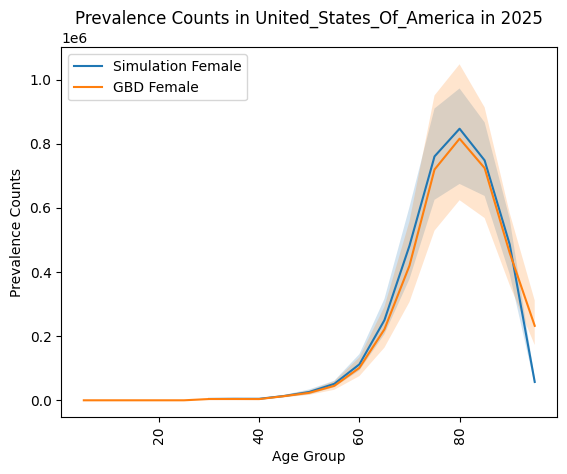

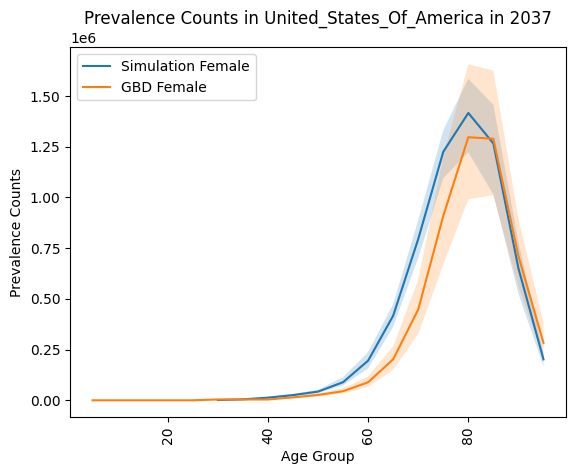

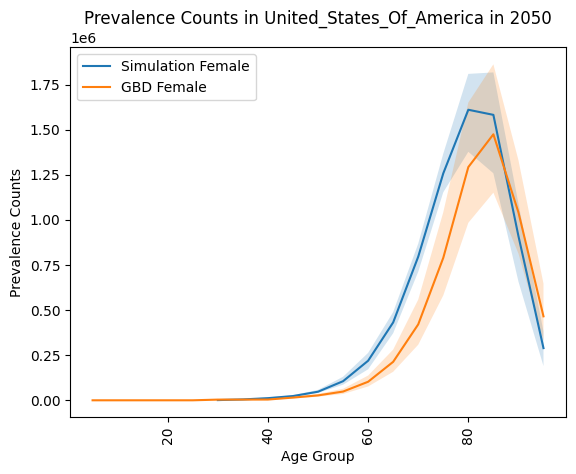

<Figure size 640x480 with 0 Axes>

In [58]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [59]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,United_States_Of_America,25.0,102057.233676,135.583353,101778.562628,101848.906776,102040.098563,102257.644353,102296.123203
1,2026,United_States_Of_America,25.0,109332.962957,651.493176,108180.180698,108228.880493,109315.006160,110324.975770,110554.045175
2,2027,United_States_Of_America,25.0,116234.605667,1223.429131,113913.930185,113955.715811,116282.283368,117973.348665,118198.209446
3,2028,United_States_Of_America,25.0,122907.700041,1897.827329,119414.702259,119459.494045,123171.400411,125734.953593,125877.445585
4,2029,United_States_Of_America,25.0,129357.156140,2627.632032,124639.909651,124668.167556,130106.611910,133129.406160,133271.597536
...,...,...,...,...,...,...,...,...,...,...
71,2096,United_States_Of_America,25.0,203303.746037,14664.457615,174493.067762,177286.091170,206766.201232,223323.630390,224332.197125
72,2097,United_States_Of_America,25.0,203315.770678,14639.605402,174536.657084,177338.398357,206651.967146,223169.314168,224170.365503
73,2098,United_States_Of_America,25.0,203317.454127,14693.235960,174609.806982,177232.982341,206698.061602,223218.414784,224054.127310
74,2099,United_States_Of_America,25.0,203264.826283,14691.218633,174345.264887,177068.244764,206685.034908,223132.538809,223930.373717


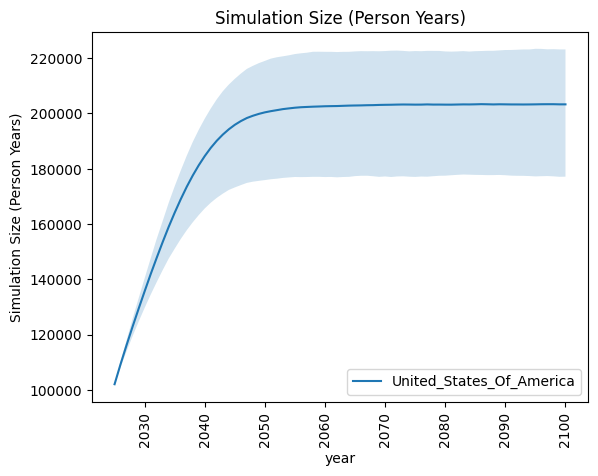

In [60]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()